# Introduction
The best way to read this labbook is in VS Code. There you can access the outline tab on the left hand side, below the explorer. The below are written per day that I work on this project, and can be read in chronological order. 

# 31-12-2022: The first step
For the gas usage article I recently wrote I really wanted to go into the hourly data. My energy provider sadly only allows me to download daily data, which I have done from 2014 to now. I cannot download the data, but it is accesible from the web interface as a graph. I though, what if I train a neural network to read the image and present the measurements as output. Once the model is trained, I can simply screenshot the graphs, save them to disk and use my trained model to extract the measurements. Note that I purposefully did not search for solutions that I can use out-of-the-box, the goal is to create a solution from scratch for my enjoyment and learning. 

As I am not sure that I will have a lot of input images that I can screencap, I will pretrain the model with graphs that I generate myself. This is much easier as I can just create graphs ad-infinitum. As an example, the graph in the webinterface looks like this:

<img src="pics/example_screenshot_webinterface.png" width="800" />

The following code tries to mimic this style and graph. I'm not sure how closely the pretrained images need to match the goal image, but I guess we'll have to find out. The code:

/usr/local/lib/python3.8/dist-packages/plotnine/scales/scale.py:102: PlotnineWarning: scale_y_continuous could not recognise parameter `position`


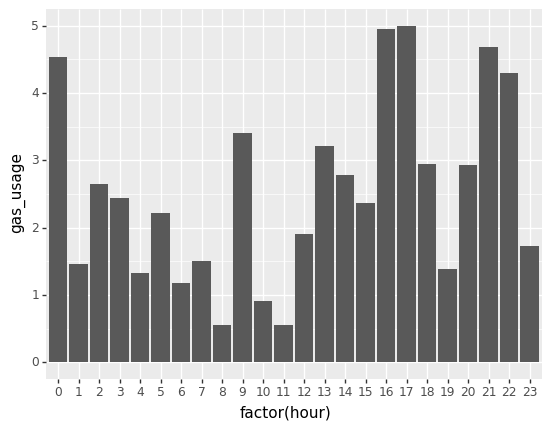

<ggplot: (8767305270498)>

In [1]:
import pandas as pd
import numpy as np
from plotnine import *

plot_data = pd.DataFrame({'hour': np.arange(0,24), 
                          'gas_usage': np.random.uniform(0,5, size=24)})

(
    ggplot(plot_data) + geom_bar(aes(x='factor(hour)', y='gas_usage'), stat='identity') + scale_y_continuous(position="right")
)

Note that the axis is on the left in stead of the right, and the style is not exactly the same. But for now we can start building towards getting the values from this kind of graph. If this works, I'm fairly sure a simple axis swap should not be the biggest issue. The next step is to create the simplest possible iteration of the above problem: a barchart with a single bar (features) and a single value (label). 

# 01-01-2023: Setup of the first experiment

The experiment we want to setup has the graph as features, and the gas usage values as labels. The goal is to train a neural network that can extract the numbers from the graph automatically. During training it needs to recognize that:

- the numbers to the left hand side represent the scale
- the height of the bar relative to this scale shows the measured value

The first experiment we want to perform is with just one bar in the graph and one number as a label. Starting simply will make it easier to see if this approach can work at all. 

But first we need to be able to generate graphs and labels on the fly using a function. We need three things from the function:

- the label
- the plot (gg object plotnine)
- 2D (black and white) or 3D (RGB) numpy array that represents the numeric color values

The first two are relatively simple to get, the last one is a bit of a challenge, so let's start with that. 

### Plotnine image to numpy array
We want to have the image as a numpy array so we can use it in a keras neural network. There are a number of steps we need to take:

- Save plotnine png stuff to an in-memory object and not on disk, see [this link](https://stackoverflow.com/questions/65528639/how-to-save-a-file-into-a-buffer).
- Convert the image to gray scale. This severly reduces the amount of data that is put into the neural network. We probably do not need the color info as the training, in my judgement, is primarily aimed to figuring out the relation between the height of the bar and the corresponding value on the y-axis. Color does not play a significant role I think. ([this link](https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays)). We could also use the [Grayscale layer](https://keras.io/api/keras_cv/layers/preprocessing/grayscale/) in Keras, but this would mean our dataset we generate would become a lot bigger. 
- Convert the png to a numpy array. ([this link](https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays))

First we make a very simple plot:

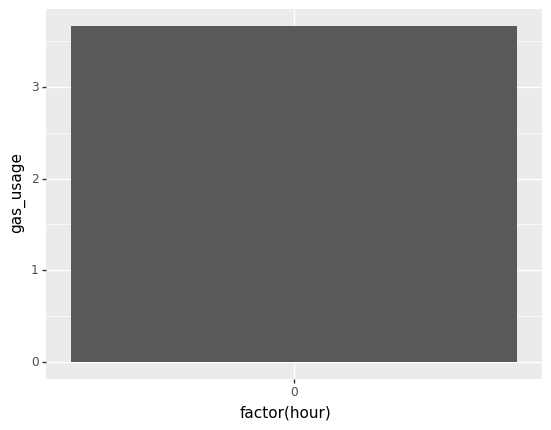

<ggplot: (8747300078933)>

In [27]:
import pandas as pd
import numpy as np
from plotnine import *

plot_data = pd.DataFrame({'hour': np.arange(0,1), 
                          'gas_usage': np.random.uniform(0,5, size=1)})

gg = (
    ggplot(plot_data) + geom_bar(aes(x='factor(hour)', y='gas_usage'), stat='identity')
)
gg

Then we load the png into an io buffer and confirm this is the exact same image:

In [44]:
import io
from tensorflow.keras.utils import load_img, img_to_array, array_to_img

buffer = io.BytesIO()
gg.save(buffer)
read_image = load_img(buffer)
read_image

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: <_io.BytesIO object at 0x7f4a3aa10630>


PIL.Image.Image

Then we convert the image to a numpy array:

In [50]:
numerical_representation = img_to_array(read_image)
numerical_representation.shape

(430, 563, 3)

The final step is to check if the array we generated contains the same image as we expected. Note we did not convert to grayscale here, that is not supported by `array_to_img`:

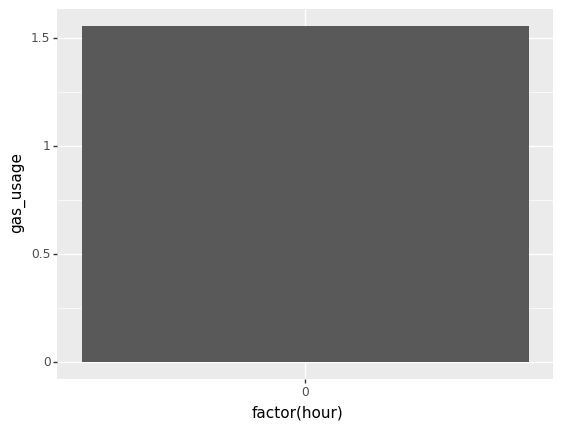

In [51]:
array_to_img(numerical_representation)

### Pooling all the code into a few functions
Now we combine the code we tested above in a set of functions we can use later on. The functions can be found in `support_functions.py`:

In [11]:
from support_functions import create_feature_label_pair
import numpy as np

label, plot, features = create_feature_label_pair(24, grayscale=False) 

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: <_io.BytesIO object at 0x7f0ed12cdae0>


0    0.501000
1    2.299832
Name: gas_usage, dtype: float64


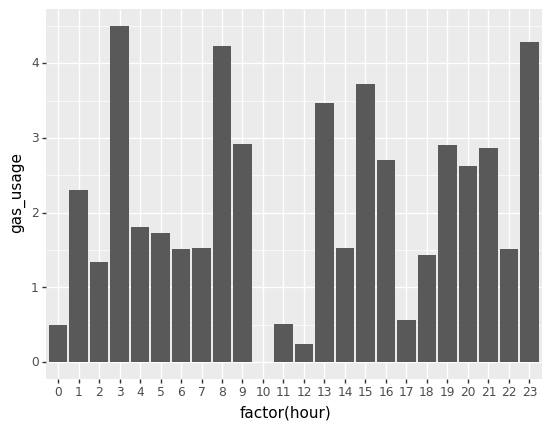

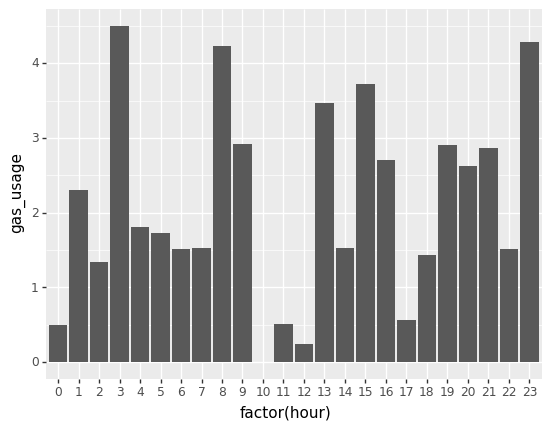

In [12]:
from tensorflow.keras.utils import array_to_img

# Test the outcome
print(label[0:2])
print(plot)
array_to_img(features)

This test checks out, the code seems to be working! The following shrinks the image quite heavily, converts to grayscale. It also seems to work fine:

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3 x 3 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: <_io.BytesIO object at 0x7f0ed09eec20>


0    1.228713
Name: gas_usage, dtype: float64


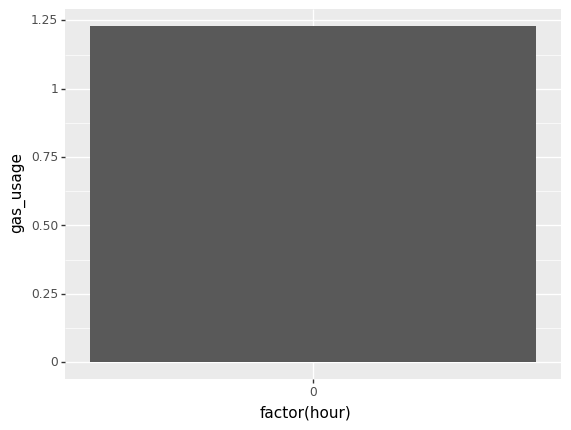


(88, 92)


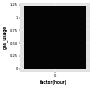

In [27]:
label, plot, features = create_feature_label_pair(1, grayscale=True, ggsave_args={'width': 3, 'height': 3, 'dpi': 30}) 

# Test the outcome
print(label[0:2])
print(plot)
print(features.shape)
array_to_img(np.expand_dims(features, axis=2)) # Epand dims because `array_to_img` needs the size 1 color dimension

# 02-01-2023: Continue building the first dataset
### Making image size consistent: upsample vs downsample
When regenerating the images multiple times, the x,y shape is not consistent. This is an issue as this makes it hard to collate the images into one big multidimensional array for keras. The following code snippet recreates the issue: 

In [4]:
from support_functions import create_feature_label_pair

def get_shape():
    label, plot, features = create_feature_label_pair(1, grayscale=True, ggsave_args={'width': 3, 'height': 3, 'dpi': 30, 'verbose': False}) 
    return features.shape

shapes = [get_shape() for i in range(10)]
shapes

[(88, 87),
 (88, 90),
 (88, 90),
 (88, 87),
 (88, 92),
 (88, 87),
 (88, 87),
 (88, 90),
 (88, 90),
 (88, 87)]

The x,y shapes change in the snippet above. The solution I feel would work is to simply interpolate the images to a fixed resolution. 

- A choice we have to make is if we create the image at a higher res using plotnine and downsample to a common resolution, or the other way around. I'm not sure if it matters at all, as long as the height of the bar is clear, and the labels on the y-axis are legible. 
- Another choice is wether we resample the png image, or the numpy array. 

A promising candidate is `tf.image.resize` from the tensorflow library. 

(874, 922, 3)


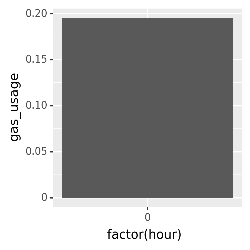

In [30]:
from support_functions import create_feature_label_pair, plot_image_array
from tensorflow.image import resize

label, plot, features = create_feature_label_pair(1, grayscale=False, ggsave_args={'width': 3, 'height': 3, 'dpi': 300, 'verbose': False}) 

print(features.shape)
plot_image_array(resize(features, (250,250)))

Rendering the image at a higher res, and then downsampling to `250x250` pxiels seems to give an image that looks readable to me. Next we integrate resizing the image into `ggplot_to_numpy_array`:

(250, 250, 1)


/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: <_io.BytesIO object at 0x7f0dc9618180>


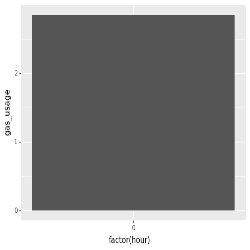

In [51]:
from tensorflow.image import resize
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
import io
import numpy as np
from support_functions import create_feature_label_pair, plot_image_array

def ggplot_to_numpy_array(gg, grayscale=True, resize_to=None, ggsave_args={}):
    '''
    Return a ggplot object (plotnine) as a numpy array. 
    Optionally reduce the image to grayscale first. 
    Any args to gg.save can be passed to `ggsave_args` as a dictonary
    '''
    buffer = io.BytesIO()
    gg.save(buffer, **ggsave_args)
    im = load_img(buffer)  

    if grayscale:
        im = im.convert('L')
    arr = img_to_array(im)
    if not resize_to is None:
        arr = resize(arr, resize_to)

    return arr  ## Note I removed the np.squeeze. Keras can simply deal with the fact that there is just one channel. It maybe even needs it looking at the behaviour of `tf.image.resize`. 

label, plot, features = create_feature_label_pair(1, grayscale=False, ggsave_args={'width': 3, 'height': 3, 'dpi': 300, 'verbose': False}) 
arr = ggplot_to_numpy_array(plot, grayscale=True, resize_to=(250,250))
print(arr.shape)
array_to_img(arr)

### Optimizing the plotting area
A lot of the plotting area is taken up by useless space:

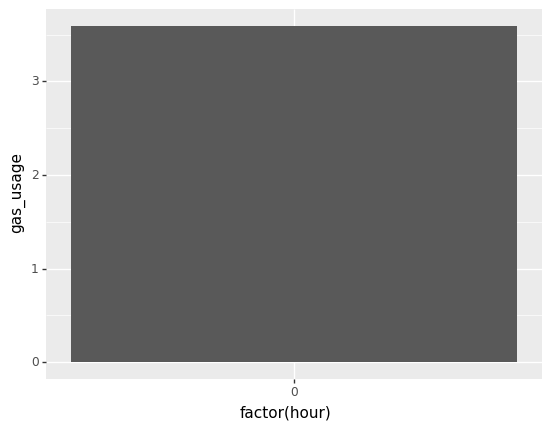

<ggplot: (8731074781669)>

In [55]:
label, plot, features = create_feature_label_pair(1, grayscale=False, ggsave_args={'dpi': 300, 'verbose': False}) 
plot

Some optimizations when taking into account that we only need the y-axis labels and the height of the bar:

- Reduce the width of the plot
- Remove axis titles

(200, 100, 1)


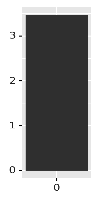

In [15]:
from support_functions import create_feature_label_pair
from plotnine import element_blank
from tensorflow.keras.utils import array_to_img

label, plot, features = create_feature_label_pair(1, grayscale=True, 
    resize_to=(200, 100), 
    ggsave_args={'dpi': 300, 'verbose': False}, 
    ggtheme_args={'figure_size': (1,3), 'axis_title': element_blank()}) 
print(features.shape)
array_to_img(features)

These combination of settings (1:3 ratio plot, 200:100 pixels) seem to be a good balance between the size of the dataset and the readability of especially the axis labels. But further exeriments actually training based on this data will show us what really works or not, but as a first guess this will suffice. 

### Creating an input dataset for Keras
Now that we have the functions all setup, we can start to generate the required input data for our Keras network. What our Keras network needs is a dataset with shape `(samples, x, y)` as features and `(samples, 1)` as labels. 

In [7]:
from support_functions import create_feature_label_pair
from plotnine import element_blank
from tensorflow.keras.utils import array_to_img
from tensorflow import stack

def get_pair():
    label, plot, features = create_feature_label_pair(1, grayscale=True, 
        resize_to=(200, 100), 
        ggsave_args={'dpi': 300, 'verbose': False}, 
        ggtheme_args={'figure_size': (1,3), 'axis_title': element_blank()}) 

    return {'label': label, 'features': features}

n = 1000
data_dict_list = [get_pair() for i in range(n)]
features = stack([el['features'] for el in data_dict_list], axis=0)
labels = stack([el['label'] for el in data_dict_list])

In [6]:
print(features.shape)
print(labels.shape)

(100, 200, 100, 1)
(100, 1)


# 06-01-2023: Feeding our data to Keras
One final step before feeding our model into Keras is to wrap the model in a generator. Normally Keras reads data from stuff like pandas `DataFrame`, numpy arrays or tensors. This means the data needs to be all in memory all at the same time. During training, there is no need for the data to all be in memory as we can batch the data. `tf.data.Dataset` provides an abstraction layer where for Keras the dataset seems as normal, but behind the abstraction all kinds of additional steps can be taken. For example, read chunks of data from a Sprak cluster, preprocessing the data, etc. 

In our case we generate the data on the fly using `plotnine`. So now we are left with two choices in term of data: generate a dataset before feeding it into Keras, or using a generator to generate the data as we go. Using a generator has the advantage that we can keep generating data ad-infinitum without having the overhead of pre-computing the dataset. A downside could be that generating the data in between slows down the training, but this depends on how long the data generation takes in comparison to the training on that data. For now, also because I want to explore generators, we'll use a generator. 

TODO:
- Look at using the above data as a generator, this would mean you can let Keras generate the data per batch and in essence train infintely. [link1](https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3) [link2](https://www.tensorflow.org/guide/data)

We can create a `tf.data.Dataset` from a [Python generator](https://wiki.python.org/moin/Generators). From what I understand in the documentation, the generator should yield a features/label pair and `Dataset` will take care of the rest. 

In [1]:
from support_functions import create_feature_label_pair
from plotnine import element_blank
from tensorflow.data import Dataset
from tensorflow import TensorSpec, float32

def plot_label_generator():
    label, plot, features = create_feature_label_pair(1, grayscale=True, 
        resize_to=(200, 100), 
        ggsave_args={'dpi': 300, 'verbose': False}, 
        ggtheme_args={'figure_size': (1,3), 'axis_title': element_blank()}) 

    yield features / 255, label   # Yield makes it a Python generator, divide by 255 to scale the data to between 0-1

plot_label_dataset = Dataset.from_generator(plot_label_generator, 
                                    output_signature = ( TensorSpec(shape=(200,100, 1), dtype=float32),     # sig: x, y, channels (1=grayscale)
                                                         TensorSpec(shape=(1,), dtype=float32),))

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!


tf.Tensor([2.518175], shape=(1,), dtype=float32)


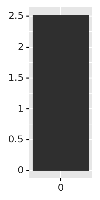

In [116]:
from tensorflow.keras.utils import array_to_img

datapoint = list(plot_label_dataset.take(1))[0]
print(datapoint[1])
array_to_img(datapoint[0])

`plot_label_dataset` is now a `tf.data.Dataset` object which can spit out image-label pairs as needed. The next step is, if I read this tutorial correctly, to simply use `plot_label_dataset` where we would normally use a normal dataset. 

Below I have a relatively simple network where I start with a regression dense layer setup I copied from Chollet (p 115). From that I expanded the number of layers and the number of neurons per layer. The idea is to create a sufficiently large enough network that will overfit, or at least show a bit of drop in loss. I don't expect to be able to solve the problem with high performance, but we should at least solve the problem somewhat. 

Some notes on the code below: 

- Note that we do not split the data explicitly, we just have two different generators that generate data for testing and training. Now test this with a very simple Keras model [I stole from](https://www.tensorflow.org/tutorials/keras/regression#regression_with_a_deep_neural_network_dnn):
- We have to use `.repeat` or else we will only be able to generate a single example features/label pair. 
- We have to set batch size on `plot_label_dataset`
- I use RMSEprop as this was what Chollet used, just as with loss = 'mse'. 
- I slowly made the learning rate for RMSprop smaller up to a value of ``
- the layer sizes taper off towards the final dense layer. This is meant to force the model to come up with more compact representations further up in the model. 

In [181]:
import tensorflow as tf
import pandas as pd
%matplotlib inline

BATCH_SIZE = 2048
no_samples_to_generate = 100000
steps_per_epoch = no_samples_to_generate // BATCH_SIZE

train_dataset = plot_label_dataset.batch(BATCH_SIZE).repeat(count=no_samples_to_generate)
test_dataset = plot_label_dataset.batch(BATCH_SIZE).repeat(count=5) # Perform validation on a number of samples to average out the loss a bit in the graph

graph_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(200, 100, 1)),     # Flatten because we feed it into dense layers
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1)                             # We predict just one value here, regression problem
])

graph_model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                            loss='mse', metrics=['mae'])
# graph_model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
#                             loss='mse', metrics=['mae'])                            
#graph_model.summary()

history = graph_model.fit(train_dataset, epochs=100, steps_per_epoch=steps_per_epoch, validation_data=test_dataset, workers=-1)
print(graph_model.evaluate(test_dataset))

pd.DataFrame({'loss': history.history['loss'], 'val_loss': history.history['val_loss']}).plot(figsize=(3,3))

Epoch 1/100
48/48 [==============================] - 9s 154ms/step - loss: 2.0959 - mae: 1.2103 - val_loss: 1.6063 - val_mae: 1.2620
Epoch 2/100
48/48 [==============================] - 9s 183ms/step - loss: 2.4922 - mae: 1.3352 - val_loss: 0.8871 - val_mae: 0.8106
Epoch 3/100
48/48 [==============================] - 8s 171ms/step - loss: 2.1100 - mae: 1.2174 - val_loss: 1.1297 - val_mae: 0.9909
Epoch 4/100
48/48 [==============================] - 7s 154ms/step - loss: 1.5479 - mae: 1.0719 - val_loss: 1.0976 - val_mae: 0.7944
Epoch 5/100
48/48 [==============================] - 8s 174ms/step - loss: 1.0110 - mae: 0.8142 - val_loss: 0.2461 - val_mae: 0.3897
Epoch 6/100
48/48 [==============================] - 7s 153ms/step - loss: 0.4732 - mae: 0.5371 - val_loss: 0.3818 - val_mae: 0.4739
Epoch 7/100
48/48 [==============================] - 8s 167ms/step - loss: 0.4324 - mae: 0.5429 - val_loss: 0.4414 - val_mae: 0.5551
Epoch 8/100
48/48 [==============================] - 7s 155ms/step - 

Observations:
- Loss definitely drops over time, the model does learn something. 
- The validation and training loss both osscilate a bit too much for my liking. 

If we look at a scatter plot of true values versus predicted we get:

100/100 [==============================] - 14s 140ms/step
1.4285375


<AxesSubplot: xlabel='true', ylabel='prediction'>

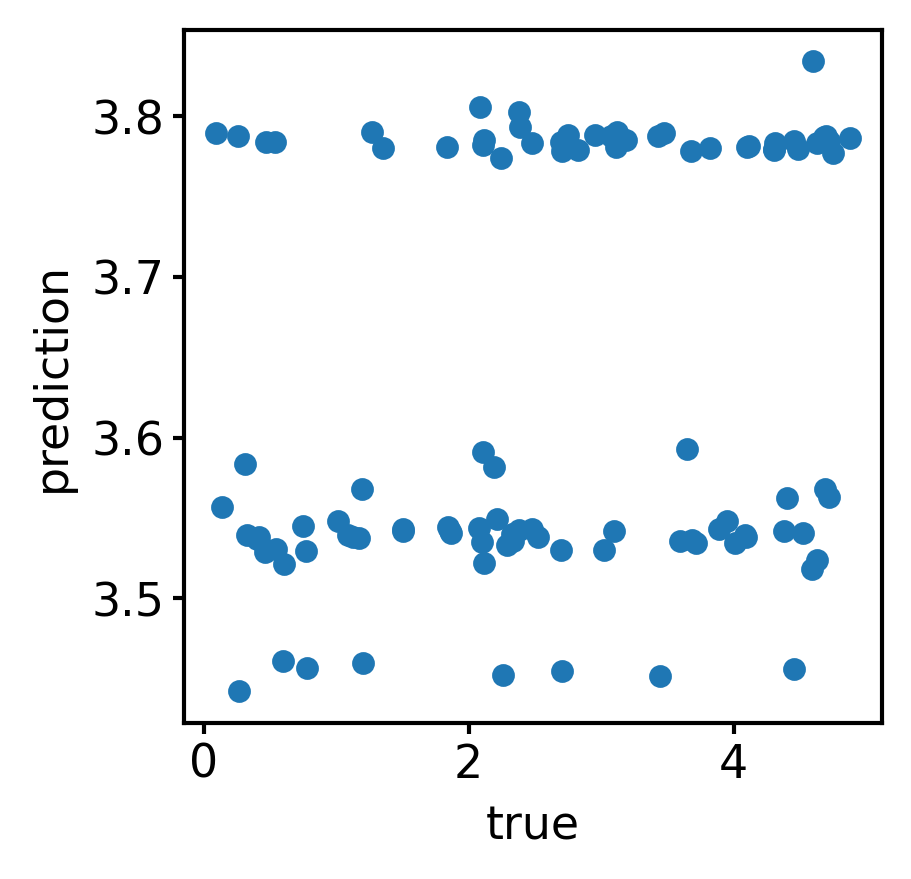

In [180]:
from sklearn.metrics import mean_absolute_error
from plotnine import *
import pandas as pd

# get 100 test observations
test_set = plot_label_dataset.repeat(100).take(100)

labels = np.concatenate([y for x, y in test_set], axis=0)
prediction = graph_model.predict(test_set)
print(mean_absolute_error(labels, prediction))

pd.DataFrame({'true': labels.flatten(), 'prediction': prediction.flatten()}).plot.scatter(x='true', y='prediction', figsize=(3,3))


which does not make me very happy. There is no clear correlation between the true and predicted values, it did however learn the approximate value range it should predict in. But it cannot detect which values are high and which are low. 

Next we want to check if the data we generated makes sense (I'm a paranoid person :)). The results below show that the plots and the labels line up. 

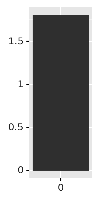

In [178]:
from tensorflow.keras.utils import array_to_img
import matplotlib.pyplot as plt
%matplotlib inline

dat = list(plot_label_dataset.repeat(3).take(3))
array_to_img(dat[1][0])


In [179]:
print(dat[1][1])

tf.Tensor([1.8047607], shape=(1,), dtype=float32)


Next steps:
- Run the analysis without the generator, to check if I really understand how the genertor works. 
- Voeg normalisation layer toe tussendoor, bv [batchnormalisation](https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/)
- Add conv layers
- Play around with dropout en pooling
- Kijk naar het optimalisaeren van de learning rate, zie [hier](https://towardsdatascience.com/the-learning-rate-finder-6618dfcb2025)

# xx-01-2023: Further dense experiemnts

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3,3) , activation="relu", input_shape=(32,32,3), padding='same') ,    # We will be using grascale images, so input_shape is probably (x,y)
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3) , activation="relu", padding='same') ,                           # The conv kernel size we can leave to (3,3) for now
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3,3) , activation="relu", padding='same') , 
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3) , activation="relu", padding='same') , 
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3,3) , activation="relu", padding='same') , 
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3) , activation="relu", padding='same') , 
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="ADAM",
            loss="sparse_categorical_crossentropy",                                             # We are dealing with a regression problem, so this loss function is not appropriate
            metrics=["accuracy"])

history=model.fit(train_images, train_labels, epochs=5, batch_size=32, validation_data=(test_images, test_labels))